In [32]:
#Visualize Samples from the model
import sys,os,glob
sys.path.append('../../')
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['lines.linewidth']=5
mpl.rcParams['lines.markersize']=10
mpl.rcParams['text.latex.unicode']=True
mpl.rcParams['text.usetex']=True
mpl.rcParams['font.family'] = 'serif' 
mpl.rcParams['font.serif'] = 'Times New Roman'
mpl.rcParams['text.latex.preamble']= ['\\usepackage{amsfonts}','\\usepackage{amsmath}']
mpl.rcParams['font.size'] = 40
mpl.rcParams['axes.labelsize']=40
mpl.rcParams['legend.fontsize']=40
#http://stackoverflow.com/questions/22408237/named-colors-in-matplotlib
from utils.misc import getConfigFile, readPickle, loadHDF5, getUniqueIDFromParams
from optvaeutils.viz import getName

DIR      = '../../expt/results_dec19/chkpt-wikicorp';
MAXEPOCH = '20'
numfeats = ['_1000','_5000','_10000','']
otypes   = ['none','finopt']

short_names = {}
if os.path.exists('../../optvaeutils/default-hmap.pkl'):
    short_names = readPickle('../../optvaeutils/default-hmap.pkl')[0]
colors = {}
colors[0] = 'r'
colors[1] = 'b'
colors[2] = 'g'
colors[3] = 'k'
colors[4] = 'y'
colors[5] = 'k'
colors[6] = 'm'
colors[7] = 'c'
colors[8] = 'b'

markers = {}
markers[0]= '*'
markers[1]= '<'
markers[2]= '>'
markers[3]= '8'
markers[4]= 'p'
markers[5]= 'v'
markers[6]= '3'
markers[7]= '2'
markers[8]= '4'

#Evalaute POB 
from datasets.load import loadDataset
from optvaedatasets.load import loadDataset as loadDataset_OVAE
dataset        =DIR.split('chkpt-')[1]
print 'Dataset:', dataset
dset = loadDataset_OVAE(dataset)

Dataset: wikicorp
Read  3  objects


In [6]:
#Visualize Training Curves (train/valid/test) across different 
datalist, l_params, namelist, svallist = [],[],[],[]
ctr = 0

results = {}
for nfeat in numfeats:
    if len(nfeat)==0:
        N = str(dset['train'].shape[1])
    else:
        N = str(nfeat[1:])
    results[N] = {}
    for otype in otypes:
        NEWDIR = DIR+nfeat+'-'+otype+'/'
        for f in glob.glob(NEWDIR+'*EP'+MAXEPOCH+'*.h5'):
            if 'pl-0' in f:
                continue
            params = readPickle(getConfigFile(f))[0]
            name   = getName(params)
            data   = loadHDF5(f)
            l_params.append(params)
            datalist.append(data)
            namelist.append(name)
            assert 'valid_perp_0' in data,'recheck'
            min_0 = np.min(data['valid_perp_0'][:,1])
            min_f = np.min(data['valid_perp_f'][:,1])
            amin  = np.argmin(data['valid_perp_f'][:,1])
            epmin = data['valid_perp_f'][amin,0]
            print N,otype,min_0,min_f
            results[N][otype] = min_f

Read  1  objects
1000 none 302.017849788 288.781806663
Read  1  objects
1000 finopt 303.86540936 277.123385422
Read  1  objects
5000 none 836.276746449 792.970685907
Read  1  objects
5000 finopt 808.904042753 722.406509281
Read  1  objects
10000 none 1150.58047006 1079.13878326
Read  1  objects
10000 finopt 1093.38048796 966.456678537
Read  1  objects
20254 none 1487.09990511 1375.78839857
Read  1  objects
20254 finopt 1395.13499469 1211.88689085


In [11]:
diff_valid = 1
bar_names_label=[]
bar_names  = []
for nfeat in numfeats:
    if len(nfeat)==0:
        N = dset['train'].shape[1]
    else:
        N = int(nfeat[1:])
    bar_names.append(str(N))
    bar_names_label.append(str(N/1000)+'k')

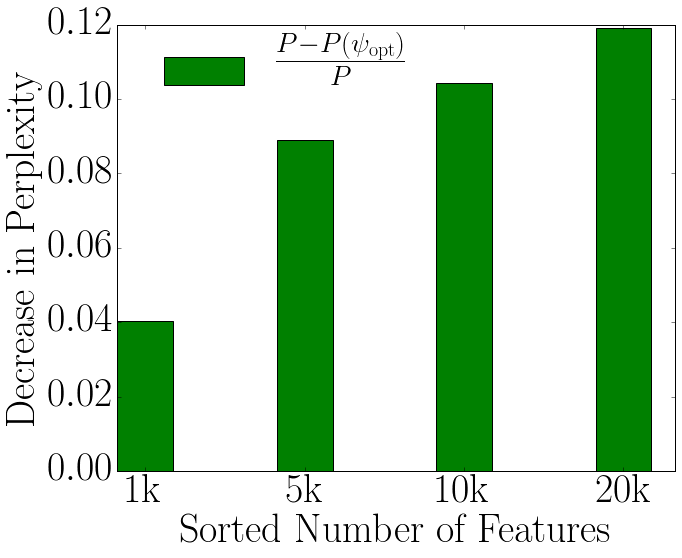

In [34]:
diff      = [(results[N]['none']-results[N]['finopt'])/(results[N]['none']) for N in bar_names]
n_groups  = len(diff)
fig, ax = plt.subplots(figsize=(10,8))

index = np.arange(n_groups)
bar_width = 0.35

error_config = {'ecolor': '0.3'}

rects1 = plt.bar(index, diff, bar_width,
                 color='g',
                 error_kw=error_config,
                 label='$\\frac{P-P (\\psi_{\\text{opt}})}{P}$')

plt.xlabel('Sorted Number of Features')
plt.ylabel('Decrease in Perplexity')
plt.xticks(index + bar_width/2, bar_names_label)#, rotation='vertical')
#plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.3),frameon=False)
plt.legend(loc='upper center', bbox_to_anchor=(0.3, 1.05),frameon=False)

fname = 'wikicorp_features.pdf'
plt.savefig(fname, bbox_inches='tight')